In [1]:
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt 
%matplotlib inline

import random as rand
from collections import defaultdict

from sklearn.feature_extraction import DictVectorizer, FeatureHasher
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from time import time

In [2]:
adult_df = pd.read_csv('datasets/adult_clean.csv')

In [3]:
adult_normalize_df = pd.read_csv('datasets/adult_normalize_clean.csv')

In [4]:
weather_df = pd.read_csv('datasets/weatherAUS_clean.csv')

In [5]:
wine_df = pd.read_csv('datasets/winequality-red.csv', sep=';')

In [6]:
titanic_df = pd.read_csv('datasets/titanic_clean.csv')

In [7]:
weather_df.head()

,Unnamed: 0,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_E,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_E,WindDir3pm_W,RainTomorrow
0,0,13.4,22.9,0.6,24.666201,7.20069,44.0,20.0,24.0,71.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0
1,1,7.4,25.1,0.0,24.666201,7.20069,44.0,4.0,22.0,44.0,...,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0
2,2,12.9,25.7,0.0,24.666201,7.20069,46.0,19.0,26.0,38.0,...,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0
3,3,9.2,28.0,0.0,24.666201,7.20069,24.0,11.0,9.0,45.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,17.5,32.3,1.0,24.666201,7.20069,41.0,7.0,20.0,82.0,...,1.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0


In [8]:
adult_df.head()

,Unnamed: 0,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia,income_>50k
0,0,39,77516,13,2174,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,50,83311,13,0,0,13,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,38,215646,9,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,53,234721,7,0,0,40,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4,28,338409,13,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
adult_df.columns

In [9]:
titanic_df.head()

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,HasTitle,Sex_female,Sex_male,...,CabinType_C,CabinType_D,CabinType_E,CabinType_F,CabinType_G,CabinType_NaN,CabinType_T,Embarked_C,Embarked_Q,Embarked_S
0,0,0,3,22.0,1,0,7.2500,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,2,1,3,26.0,0,0,7.9250,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,3,1,1,35.0,1,0,53.1000,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,4,0,3,35.0,0,0,8.0500,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [10]:
def features_to_dicts(df):
    columns = df.columns
    dicts = []
   
    for index, row in df.iterrows():
        feature_dict = {}
        for col in columns:
            feature_dict[col] = row[col]
        dicts.append(feature_dict)
    return dicts

In [11]:
def n_nonzero_columns(X):
    return len(np.unique(X.nonzero()[1]))

In [12]:
adult_features = adult_normalize_df.drop(['Unnamed: 0', 'income_>50k'], axis=1)
adult_Y = adult_normalize_df['income_>50k'].values

In [13]:
adult_dict = features_to_dicts(adult_features)

In [15]:
adult_X = adult_features.values

In [16]:
adult_X.shape

(48842, 92)

In [17]:
dictVectorizer = DictVectorizer()
adult_X_dict = dictVectorizer.fit_transform(adult_dict)

In [18]:
adult_X_dict.shape

(48842, 92)

In [19]:
print("Found %d unique terms" % len(dictVectorizer.get_feature_names()))

Found 92 unique terms


In [59]:
hasher75 = FeatureHasher(n_features=math.ceil(len(adult_features.columns)*0.75))
adult_X_hash75 = hasher75.transform(adult_dict)

In [60]:
adult_X_hash75.shape

(48842, 69)

In [61]:
print("unique terms: ", n_nonzero_columns(adult_X_hash75))

unique terms:  53


In [56]:
hasher50 = FeatureHasher(n_features=math.ceil(len(adult_features.columns)*0.50))
adult_X_hash50 = hasher50.transform(adult_dict)

In [57]:
adult_X_hash50.shape

(48842, 46)

In [58]:
print("unique terms: ", n_nonzero_columns(adult_X_hash50))

unique terms:  39


In [52]:
math.ceil(len(adult_features.columns)*0.15)

14

In [53]:
hasher15 = FeatureHasher(n_features=math.ceil(len(adult_features.columns)*0.15))
adult_X_hash15 = hasher15.transform(adult_dict)

In [54]:
adult_X_hash15.shape

(48842, 14)

In [55]:
print("unique terms: ", n_nonzero_columns(adult_X_hash15))

unique terms:  14


In [51]:
adult_X_hash15.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [26]:
clf_ridge_default = RidgeClassifier()#.fit(adult_features, adult_Y)
t0 = time()
cross_val_ridge_default = cross_val_score(clf_ridge_default, adult_features, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_ridge_default)
print(np.mean(cross_val_ridge_default))
# print(clf_ridge_default.score(adult_features, adult_Y))

duration 0.620002031326294
[0.83938991 0.83764971 0.84316134 0.84203522 0.84316134]
0.8410795036933845


In [27]:
clf_ridge_dict = RidgeClassifier()#.fit(adult_X_dict, adult_Y)
t0 = time()
cross_val_ridge_dict = cross_val_score(clf_ridge_dict, adult_X_dict, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_ridge_dict)
print(np.mean(cross_val_ridge_dict))
# print(clf_ridge_dict.score(adult_X_dict, adult_Y))

duration 0.6900262832641602
[0.83918518 0.8379568  0.84295659 0.84234234 0.84275184]
0.8410385515565167


In [29]:
clf_ridge_hash75 = RidgeClassifier()#.fit(adult_X_hash75, adult_Y)
t0 = time()
cross_val_ridge_hash75 = cross_val_score(clf_ridge_hash75, adult_X_hash75, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_ridge_hash75)
print(np.mean(cross_val_ridge_hash75))
# print(clf_ridge_hash.score(adult_X_hash, adult_Y))

duration 0.2510361671447754
[0.81963353 0.81850752 0.82063882 0.82330057 0.81859132]
0.8201343541961824


In [31]:
clf_ridge_hash50 = RidgeClassifier()#.fit(adult_X_hash75, adult_Y)
t0 = time()
cross_val_ridge_hash50 = cross_val_score(clf_ridge_hash50, adult_X_hash50, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_ridge_hash50)
print(np.mean(cross_val_ridge_hash50))
# print(clf_ridge_hash.score(adult_X_hash, adult_Y))

duration 0.2180330753326416
[0.80898761 0.81042072 0.80958231 0.81623669 0.81111794]
0.8112690538834464


In [62]:
clf_ridge_hash15 = RidgeClassifier()#.fit(adult_X_hash15, adult_Y)
t0 = time()
cross_val_ridge_hash15 = cross_val_score(clf_ridge_hash15, adult_X_hash15, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_ridge_hash15)
print(np.mean(cross_val_ridge_hash15))
# print(clf_ridge_hash.score(adult_X_hash, adult_Y))

duration 0.18900728225708008
[0.76323063 0.76548265 0.76208026 0.76453726 0.76351351]
0.7637688633645232


In [32]:
n_estimators = math.ceil(adult_X.shape[1]/2)

In [33]:
max_depth = math.ceil(adult_X.shape[1]*0.8)

In [34]:
clf_randfor_default = RandomForestClassifier(n_jobs=4, n_estimators=n_estimators, min_samples_split=3, max_depth=max_depth)#.fit(adult_features, adult_Y)
t0 = time()
cross_val_randfor_default = cross_val_score(clf_randfor_default, adult_features, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_randfor_default)
print(np.mean(cross_val_randfor_default))
# print(clf_randfor_default.score(adult_features, adult_Y))

duration 7.055613040924072
[0.8579179  0.85720135 0.85913186 0.85268223 0.85575348]
0.8565373644706227


In [35]:
clf_randfor_dict = RandomForestClassifier(n_jobs=4, n_estimators=n_estimators, min_samples_split=3, max_depth=max_depth)#.fit(adult_X_dict, adult_Y)
t0 = time()
cross_val_randfor_dict = cross_val_score(clf_randfor_dict, adult_X_dict, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_randfor_dict)
print(np.mean(cross_val_randfor_dict))
# print(clf_randfor_dict.score(adult_X_dict, adult_Y))

duration 62.79384183883667
[0.85628007 0.85750845 0.85708436 0.85524161 0.8544226 ]
0.856107416287578


In [37]:
clf_randfor_hash75 = RandomForestClassifier(n_jobs=4, n_estimators=n_estimators, min_samples_split=3, max_depth=max_depth)#.fit(adult_X_hash, adult_Y)
t0 = time()
cross_val_randfor_hash75 = cross_val_score(clf_randfor_hash75, adult_X_hash75, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_randfor_hash75)
print(np.mean(cross_val_randfor_hash75))
# print(clf_randfor_hash.score(adult_X_hash, adult_Y))

duration 17.56114888191223
[0.85453987 0.85576825 0.85984848 0.85227273 0.85370598]
0.8552270616683556


In [39]:
clf_randfor_hash50 = RandomForestClassifier(n_jobs=4, n_estimators=n_estimators, min_samples_split=3, max_depth=max_depth)#.fit(adult_X_hash, adult_Y)
t0 = time()
cross_val_randfor_hash50 = cross_val_score(clf_randfor_hash50, adult_X_hash50, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_randfor_hash50)
print(np.mean(cross_val_randfor_hash50))
# print(clf_randfor_hash.score(adult_X_hash, adult_Y))

duration 18.017691135406494
[0.85310677 0.84890982 0.85217035 0.84899672 0.84971335]
0.8505794017898634


In [63]:
clf_randfor_hash15 = RandomForestClassifier(n_jobs=4, n_estimators=n_estimators, min_samples_split=3, max_depth=max_depth)#.fit(adult_X_hash, adult_Y)
t0 = time()
cross_val_randfor_hash15 = cross_val_score(clf_randfor_hash15, adult_X_hash15, adult_Y, cv=5)
duration = time() - t0
print("duration", duration)
print(cross_val_randfor_hash15)
print(np.mean(cross_val_randfor_hash15))
# print(clf_randfor_hash.score(adult_X_hash, adult_Y))

duration 18.7160005569458
[0.85146893 0.84911455 0.85391073 0.84520885 0.84602785]
0.8491461796994605


In [112]:
def compare_feature_hashing(features, features_dict, Y):
    features_X = features.values

    clf_ridge_default = RidgeClassifier()
    t0 = time()
    cross_val_ridge_default = cross_val_score(clf_ridge_default, features_X, Y, cv=5)
    duration = time() - t0
    print("ridge_default duration", duration)
    print(np.mean(cross_val_ridge_default))
    print()
    
    dictVectorizer = DictVectorizer()
    features_X_dict = dictVectorizer.fit_transform(features_dict)

    clf_ridge_dict = RidgeClassifier()
    t0 = time()
    cross_val_ridge_dict = cross_val_score(clf_ridge_dict, features_X_dict, Y, cv=5)
    duration = time() - t0
    print("ridge_dict duration", duration)
    print(np.mean(cross_val_ridge_dict))
    print()
    
    n_estimators = math.ceil(features_X.shape[1]/2)
    max_depth = math.ceil(features_X.shape[1]*0.8)

    clf_randfor_default = RandomForestClassifier(n_jobs=4, n_estimators=n_estimators, min_samples_split=3, max_depth=max_depth)
    t0 = time()
    cross_val_randfor_default = cross_val_score(clf_randfor_default, features_X, Y, cv=5)
    duration = time() - t0
    print("randfor_default duration", duration)
    print(np.mean(cross_val_randfor_default))
    print()

    clf_randfor_dict = RandomForestClassifier(n_jobs=4, n_estimators=n_estimators, min_samples_split=3, max_depth=max_depth)
    t0 = time()
    cross_val_randfor_dict = cross_val_score(clf_randfor_dict, features_X_dict, Y, cv=5)
    duration = time() - t0
    print("randfor_dict duration", duration)
    print(np.mean(cross_val_randfor_dict))
    print()

    cross_val_ridge_hashes = []
    cross_val_randfor_hashes = []
    for i in range(2, 11, 2):
        percent = 0.1*i
        n_features = math.ceil(features_X.shape[1]*percent)
        print("hasher percent", percent, "n_features", n_features)
        print()
        hasher = FeatureHasher(n_features=n_features)
        features_X_hash = hasher.transform(features_dict)

        clf_ridge_hash = RidgeClassifier()
        t0 = time()
        cross_val_ridge_hash = cross_val_score(clf_ridge_hash, features_X_hash, Y, cv=5)
        duration = time() - t0
        cross_val_ridge_hashes.append(np.mean(cross_val_ridge_hash))
        print("ridge_hash", i*100, "duration", duration)
        print(np.mean(cross_val_ridge_hash))
        print()

        clf_randfor_hash = RandomForestClassifier(n_jobs=4, n_estimators=n_estimators, min_samples_split=3, max_depth=max_depth)
        t0 = time()
        cross_val_randfor_hash = cross_val_score(clf_randfor_hash, features_X_hash, Y, cv=5)
        duration = time() - t0
        cross_val_randfor_hashes.append(np.mean(cross_val_randfor_hash))
        print("randfor_hash", i*10, "duration", duration)
        print(np.mean(cross_val_randfor_hash))
        print()
    
    t = np.arange(2, 11, 2)

    fig, ax = plt.subplots(1, 3, figsize=(15,5), tight_layout=True)
    
    ax[0].plot(t, np.mean(cross_val_ridge_default)*np.ones(5), label='ridge_default')
    ax[0].plot(t, np.mean(cross_val_ridge_dict)*np.ones(5), label='ridge_dict')
    ax[0].plot(t, cross_val_ridge_hashes, label='ridge_hashes')
    ax[0].set(xlabel='hash %', ylabel='mean CV score', title='ridge')
    ax[0].legend()
    
    ax[1].plot(t, np.mean(cross_val_randfor_default)*np.ones(5), label='randfor_default')
    ax[1].plot(t, np.mean(cross_val_randfor_dict)*np.ones(5), label='randfor_dict')
    ax[1].plot(t, cross_val_randfor_hashes, label='randfor_hashes')
    ax[1].set(xlabel='hash %', ylabel='mean CV score', title='random forest')
    ax[1].legend()
    
    ax[2].plot(t, np.mean(cross_val_ridge_default)*np.ones(5), label='ridge_default')
    ax[2].plot(t, np.mean(cross_val_ridge_dict)*np.ones(5), label='ridge_dict')
    ax[2].plot(t, cross_val_ridge_hashes, label='cross_val_ridge_hashes')
    ax[2].plot(t, np.mean(cross_val_randfor_default)*np.ones(5), label='randfor_default')
    ax[2].plot(t, np.mean(cross_val_randfor_dict)*np.ones(5), label='randfor_dict')
    ax[2].plot(t, cross_val_randfor_hashes, label='randfor_hashes')
    ax[2].set(xlabel='hash %', ylabel='mean CV score', title='ridge and random forest')
    ax[2].legend()
    
    plt.show()

ridge_default duration 0.3859977722167969
0.8410795036933845

ridge_dict duration 0.665001630783081
0.8410385515565167

randfor_default duration 5.5634331703186035
0.8563531710271397

randfor_dict duration 61.85512375831604
0.8560665312200783

hasher percent 0.2 n_features 19
ridge_hash 20 duration 0.19203448295593262
0.8150157981896132

randfor_hash 20 duration 21.27686071395874
0.8259079788151341

hasher percent 0.4 n_features 37
ridge_hash 40 duration 0.25098609924316406
0.8157733676594358

randfor_hash 40 duration 20.1443293094635
0.8531182770818353

hasher percent 0.6000000000000001 n_features 56
ridge_hash 60 duration 0.3040347099304199
0.8319480281144731

randfor_hash 60 duration 20.46769952774048
0.8533844292929154

hasher percent 0.8 n_features 74
ridge_hash 80 duration 0.2830338478088379
0.8293068510772473

randfor_hash 80 duration 19.881236791610718
0.8543057234734992

hasher percent 1.0 n_features 92
ridge_hash 100 duration 0.2569704055786133
0.8175750374184195

randfor_has

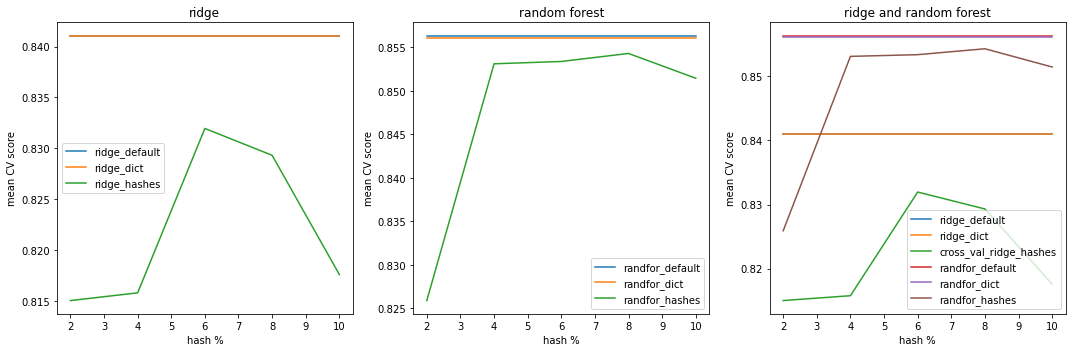

In [115]:
compare_feature_hashing(adult_features, adult_dict, adult_Y)

In [79]:
titanic_df

,Unnamed: 0,Survived,Pclass,Age,SibSp,Parch,Fare,HasTitle,Sex_female,Sex_male,...,CabinType_C,CabinType_D,CabinType_E,CabinType_F,CabinType_G,CabinType_NaN,CabinType_T,Embarked_C,Embarked_Q,Embarked_S
0,0,0,3,22.000000,1,0,7.2500,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1,1,1,1,38.000000,1,0,71.2833,0,1,0,...,1,0,0,0,0,0,0,1,0,0
2,2,1,3,26.000000,0,0,7.9250,0,1,0,...,0,0,0,0,0,1,0,0,0,1
3,3,1,1,35.000000,1,0,53.1000,0,1,0,...,1,0,0,0,0,0,0,0,0,1
4,4,0,3,35.000000,0,0,8.0500,0,0,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,413,0,3,29.881138,0,0,8.0500,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1305,414,1,1,39.000000,0,0,108.9000,1,1,0,...,1,0,0,0,0,0,0,1,0,0
1306,415,0,3,38.500000,0,0,7.2500,0,0,1,...,0,0,0,0,0,1,0,0,0,1
1307,416,0,3,29.881138,0,0,8.0500,0,0,1,...,0,0,0,0,0,1,0,0,0,1


In [83]:
titanic_features = titanic_df.drop(['Unnamed: 0', 'Survived'], axis=1)
titanic_dict = features_to_dicts(titanic_features)
titanic_Y = titanic_df['Survived'].values

ridge_default duration 0.018001317977905273
0.8541838495510514

ridge_dict duration 0.026998519897460938
0.8549472083296774

randfor_default duration 0.12700223922729492
0.8266151911321693

randfor_dict duration 0.1419999599456787
0.8327425345851246

hasher percent 0.2 n_features 4
ridge_hash 20 duration 0.018004417419433594
0.6852154075633938

randfor_hash 20 duration 0.12755775451660156
0.7119680617706413

hasher percent 0.4 n_features 8
ridge_hash 40 duration 0.02000117301940918
0.7066070018425901

randfor_hash 40 duration 0.13200068473815918
0.7585738937147203

hasher percent 0.6000000000000001 n_features 13
ridge_hash 60 duration 0.02100396156311035
0.8427159193939925

randfor_hash 60 duration 0.18202853202819824
0.8243163405574565

hasher percent 0.8 n_features 16
ridge_hash 80 duration 0.024959564208984375
0.8090696382088854

randfor_hash 80 duration 0.13000106811523438
0.81743441256471

hasher percent 1.0 n_features 20
ridge_hash 100 duration 0.022002458572387695
0.845005995729

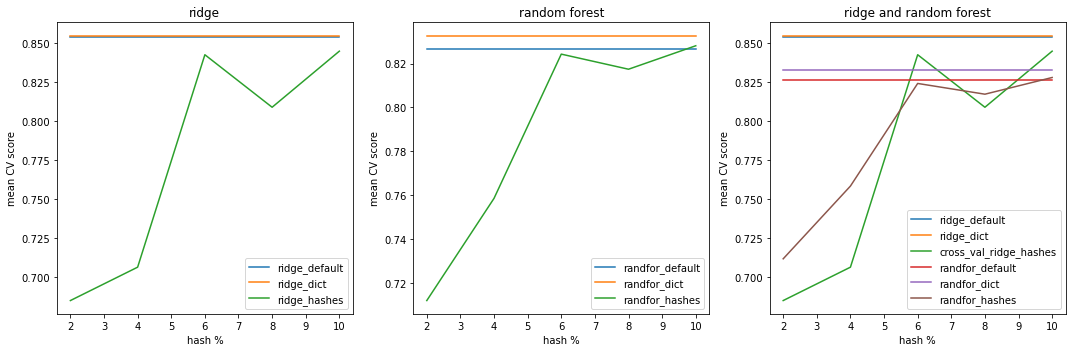

In [114]:
compare_feature_hashing(titanic_features, titanic_dict, titanic_Y)

In [118]:
weather_features = weather_df.drop(['Unnamed: 0', 'RainTomorrow'], axis=1)
weather_dict = features_to_dicts(weather_features)
weather_Y = weather_df['RainTomorrow'].values

ridge_default duration 0.434999942779541
0.8442400853928895

ridge_dict duration 1.0910344123840332
0.8441333442811396

randfor_default duration 4.760415077209473
0.8418589375153955

randfor_dict duration 49.23134398460388
0.8417850398226456

hasher percent 0.2 n_features 6
ridge_hash 20 duration 0.24800753593444824
0.8323261351506692

randfor_hash 20 duration 23.790918350219727
0.82796617127843

hasher percent 0.4 n_features 12
ridge_hash 40 duration 0.3789970874786377
0.8403070859676494

randfor_hash 40 duration 27.32373332977295
0.8357336398719106

hasher percent 0.6000000000000001 n_features 18
ridge_hash 60 duration 0.5419628620147705
0.8403727728056489

randfor_hash 60 duration 31.49481773376465
0.8386320715986534

hasher percent 0.8 n_features 24
ridge_hash 80 duration 0.5210001468658447
0.8397815912636505

randfor_hash 80 duration 27.121891975402832
0.8366532556039082

hasher percent 1.0 n_features 29
ridge_hash 100 duration 0.656991720199585
0.8381147877494047

randfor_hash 10

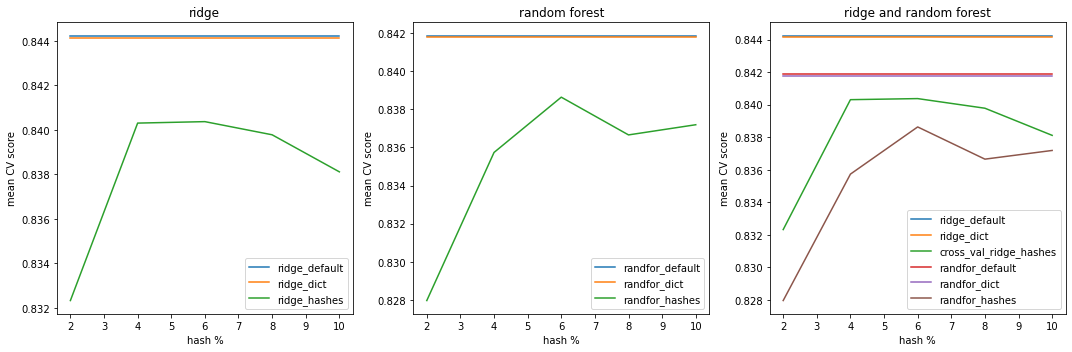

In [119]:
compare_feature_hashing(weather_features, weather_dict, weather_Y)

In [132]:
wine_df['quality'].unique()

array([5, 6, 7, 4, 8, 3], dtype=int64)

In [133]:
wine_features = wine_df.drop(['quality'], axis=1)
wine_dict = features_to_dicts(wine_features)
wine_Y = wine_df['quality'].values
wine_Y_binary = (wine_df['quality'] >= 6).values

ridge_default duration 0.029002666473388672
0.5653683385579937

ridge_dict duration 0.09599566459655762
0.5647452978056426

randfor_default duration 0.09100031852722168
0.5447139498432602

randfor_dict duration 0.1060030460357666
0.5447257053291537

hasher percent 0.2 n_features 3
ridge_hash 20 duration 0.03500008583068848
0.5109345611285266

randfor_hash 20 duration 0.09400224685668945
0.4890595611285266

hasher percent 0.4 n_features 5
ridge_hash 40 duration 0.04200029373168945
0.5584972570532916

randfor_hash 40 duration 0.1011192798614502
0.5096708463949844

hasher percent 0.6000000000000001 n_features 7
ridge_hash 60 duration 0.03899979591369629
0.5196865203761755

randfor_hash 60 duration 0.11897969245910645
0.5178448275862069

hasher percent 0.8 n_features 9
ridge_hash 80 duration 0.06401515007019043
0.5559933385579938

randfor_hash 80 duration 0.10799336433410645
0.5284757053291536

hasher percent 1.0 n_features 11
ridge_hash 100 duration 0.05201005935668945
0.5616144200626959


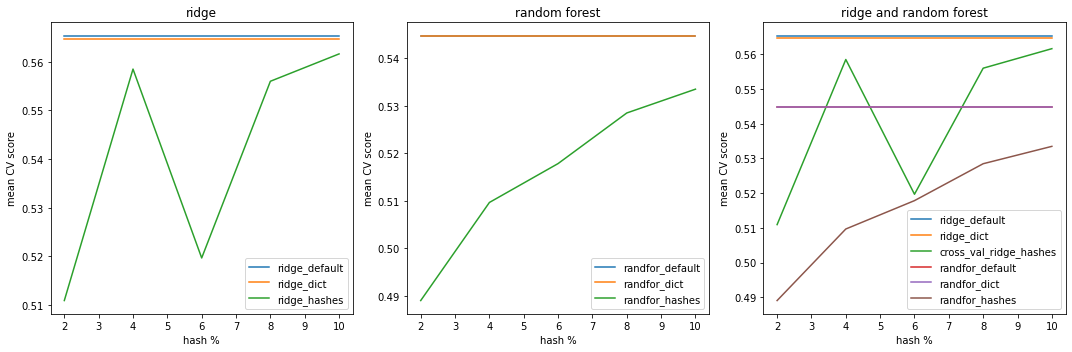

In [122]:
compare_feature_hashing(wine_features, wine_dict, wine_Y)

ridge_default duration 0.01700282096862793
0.7348373824451411

ridge_dict duration 0.03603363037109375
0.7273334639498432

randfor_default duration 1.6489648818969727
0.7054388714733543

randfor_dict duration 0.10600399971008301
0.7098177899686521

hasher percent 0.2 n_features 3
ridge_hash 20 duration 0.01600050926208496
0.636634012539185

randfor_hash 20 duration 0.0930018424987793
0.6122629310344827

hasher percent 0.4 n_features 5
ridge_hash 40 duration 0.019947290420532227
0.7067006269592476

randfor_hash 40 duration 0.11100149154663086
0.6941673197492163

hasher percent 0.6000000000000001 n_features 7
ridge_hash 60 duration 0.019003868103027344
0.6597707680250784

randfor_hash 60 duration 0.10899829864501953
0.6554114420062696

hasher percent 0.8 n_features 9
ridge_hash 80 duration 0.022996902465820312
0.6991986677115988

randfor_hash 80 duration 0.1381998062133789
0.6778977272727272

hasher percent 1.0 n_features 11
ridge_hash 100 duration 0.05300092697143555
0.7223432601880878


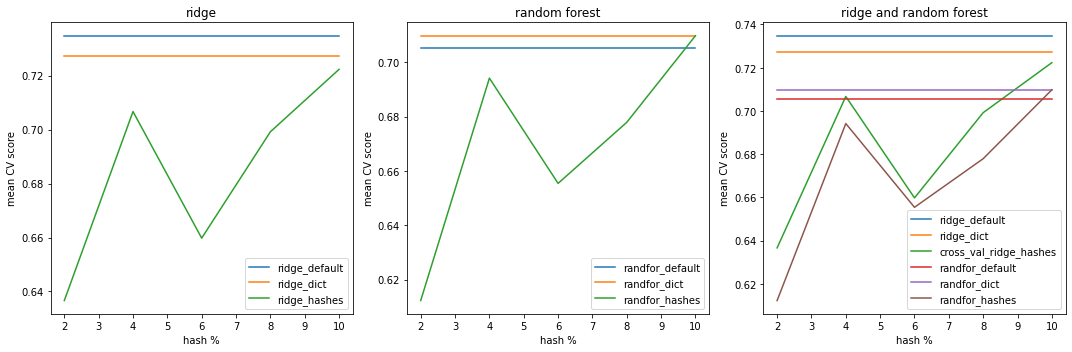

In [135]:
compare_feature_hashing(wine_features, wine_dict, wine_Y_binary)